In [1]:
import utils

from scipy.stats import shapiro
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy.stats import kruskal
from scipy.stats import ks_2samp
from scipy.stats import normaltest
from scipy.stats import anderson
import researchpy as rp
import scipy.stats as stats

from sklearn.model_selection import StratifiedKFold as KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik



from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler




PATH = '/Users/mimi/Desktop/PYTHON/TURING/HOME/MachLearning/S2/data/healthcare-dataset-stroke-data.csv'

df = pd.read_csv(PATH)
df.drop(columns='id', inplace=True)

df.drop(df[df.gender == 'Other'].index,inplace=True)
df.reset_index(drop=True,inplace=True)

df.gender = df.gender.map({'Male':0,'Female':1})
df.ever_married = df.ever_married.map({'No':0,'Yes':1})
df.work_type = df.work_type.map({'Private':0,'Self-employed':1,'children':2,'Govt_job':3,'Never_worked':4})
df.Residence_type = df.Residence_type.map({'Urban':0,'Rural':1})
df.smoking_status = df.smoking_status.map({'never smoked':0,'formerly smoked':1,'smokes':2,'Unknown':3})

imputer = SimpleImputer(strategy="mean")
df['bmi'] = imputer.fit_transform(df[['bmi']])
data1 = df[df['stroke'] == 1]['age']
data2 = df[df['stroke'] == 0]['age']

df.head()


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1,0,0,228.69,36.60000,1,1
1,1,61.0,0,0,1,1,1,202.21,28.89456,0,1
2,0,80.0,0,1,1,0,1,105.92,32.50000,0,1
3,1,49.0,0,0,1,0,0,171.23,34.40000,2,1
4,1,79.0,1,0,1,1,1,174.12,24.00000,0,1


## In the following code, I sample the non stroke patients with the same distribution as the population.

In [2]:
data = utils.create_folds(df[df['stroke'] == 0], fold_length=len(data1))
from scipy.stats import ks_2samp

for fold in np.sort(data.Fold.unique()):
    if fold == 0:
        continue  # Skip the comparison with itself
    print(f'Fold 0 vs {fold}:', ks_2samp(data.loc[data.Fold==0, 'stroke'], data.loc[data.Fold==fold, 'stroke']))

Fold 0 vs 1: KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0, statistic_sign=1)
Fold 0 vs 2: KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0, statistic_sign=1)
Fold 0 vs 3: KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0, statistic_sign=1)
Fold 0 vs 4: KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0, statistic_sign=1)
Fold 0 vs 5: KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0, statistic_sign=1)
Fold 0 vs 6: KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0, statistic_sign=1)
Fold 0 vs 7: KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0, statistic_sign=1)
Fold 0 vs 8: KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0, statistic_sign=1)
Fold 0 vs 9: KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0, statistic_sign=1)
Fold 0 vs 10: KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0, statistic_sign=1)
Fold 0 vs 11: KstestResult(statistic=0.0, pvalue=1.0, statistic_locat

/Users/mimi/Desktop/PYTHON/TURING/HOME/MachLearning/S2/notebooks/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fold'] = -1


## Tests

In [3]:
data1 = df[df['stroke'] == 1]['age']
data2 = data[data['Fold'] == 17]['age']

Independence Test

In [ ]:
stats.ttest_ind(data1, data2)

strong evidence to reject null hypothesis


Next we have HOMOGENEITY OF VARIANCE


In [ ]:
stats.levene(data1, data2, center= 'mean')


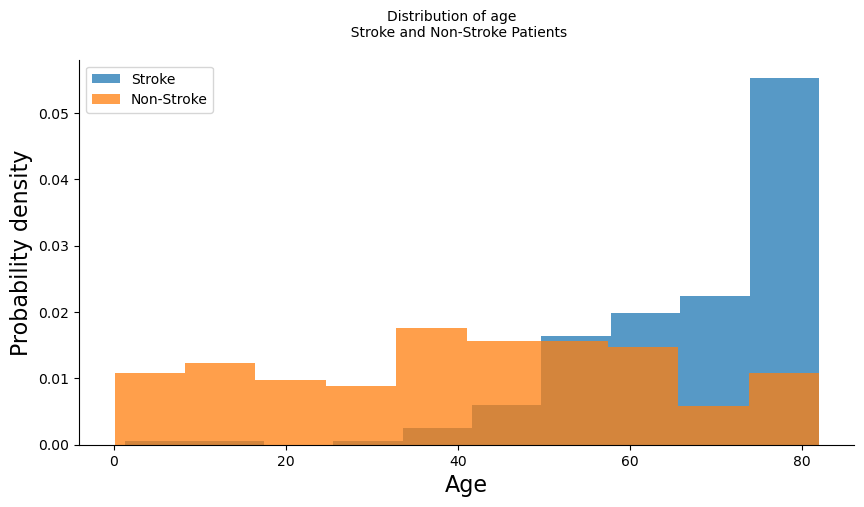

In [5]:
fig = plt.figure(figsize=(10, 5))
#ax = fig.add_subplot(111)



p_bp_stroke = plt.hist(data1, label="Stroke",
                       density=True,
                       alpha=0.75)
p_bp_nonstroke = plt.hist(data2, label="Non-Stroke",
                          density=True,
                          alpha=0.75)

plt.suptitle("Distribution of age \n  Stroke and Non-Stroke Patients", fontsize=10)
plt.xlabel("Age", fontsize=16)
plt.ylabel("Probability density", fontsize=16)

plt.legend()



sns.despine()
plt.show()


This means we have to handle heteroskedasticity (unequal varience) and use Welches t-test!


First we test normality with shapiro

In [12]:
stats.shapiro(data1)


ShapiroResult(statistic=0.8781338334083557, pvalue=3.1740154124784703e-13)

In [13]:
stats.shapiro(data2)


ShapiroResult(statistic=0.9702313542366028, pvalue=4.53601787739899e-05)

Looks like both samples do not follow the normal distribution. therefore we abandone this test and continue with bootstraping 

95% Confidence Interval: [-3.80511647  3.8100241 ]


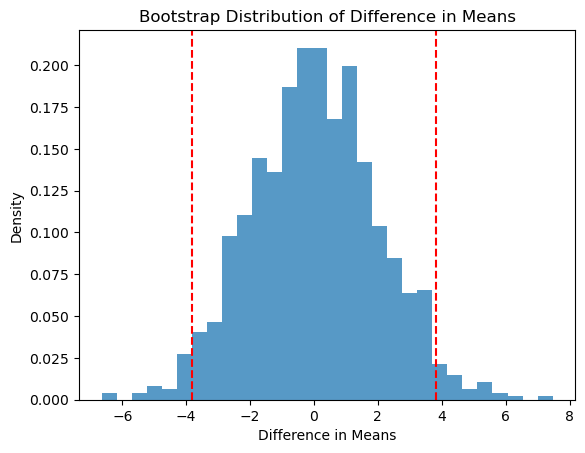

Observed Difference in Means: 26.866184738955823
P-value: 0.000


In [15]:
bootstrap_statistics = utils.bootstrap_sample(data1, data2, utils.difference_in_means)
plt.hist(bootstrap_statistics, bins=30, density=True, alpha=0.75)
plt.xlabel('Difference in Means')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of Difference in Means')

conf_interval = np.percentile(bootstrap_statistics, [2.5, 97.5])
print('95% Confidence Interval:', conf_interval)

plt.axvline(x=conf_interval[0], color='red', linestyle='--')
plt.axvline(x=conf_interval[1], color='red', linestyle='--')

plt.show()

observed_difference = utils.difference_in_means(data1, data2)
p_value = np.mean(np.abs(bootstrap_statistics) >= np.abs(observed_difference))

if p_value < 0.001:
    formatted_p_value = '0.000'
else:
    formatted_p_value = f'{p_value:.3f}'

print('Observed Difference in Means:', observed_difference)
print('P-value:', formatted_p_value)

we therefore conclude theres strong evidence against the null hypothesis and there is a statistically significant difference between the means of both age groups